### Test the dataset maker and train a model using FastAI approach
The dataset is built using opensoundscape's AudioSplittingDataset and AudioFileDataset, then labelled using a custom heuristic. This notebook attempts to run a training cycle by passing the Opso DataLoader into a FastAI Learner. 


In [1]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor
import torch

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# load the raw dataframe
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "processed" / "train_set"
df_train: pd.DataFrame = pd.read_pickle(train_df_path / "train_set.pkl")
df_train.head(2)

,Unnamed: 0,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,...,spectrogram_url,clip_url,sensorId,tasks,status,recording_url,latitude,longitude,location_buffer_m,file_type
1,1752,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87956,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac
2,1758,BU,Amplitude Quality Testing 2020,293,AM-403-SE2,36043,2017-06-15 04:46:00,92051,NaN,87898,...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,174,Published - Private,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,54.607774,-110.681271,NaN,flac


### Take a sample of the recordings
Training loop is slow with all the data - use a sample to speed things up. 
Sample at the recording level

In [3]:
import random
unique_recordings = list(set(df_train.recording_id))
sample_size = round(0.1* len(unique_recordings))
sample_recordings = random.sample(unique_recordings, sample_size)
df_train_sample = df_train[df_train.recording_id.isin(sample_recordings)]
df_train_sample.shape, df_train.shape

((43948, 70), (432974, 70))

65 not downloaded
downloading 0 clips
skipped 0 previously downloaded files


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/data/build.py:170: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.drop(df.loc[df.target_presence == False][df.target_absence == False].index)


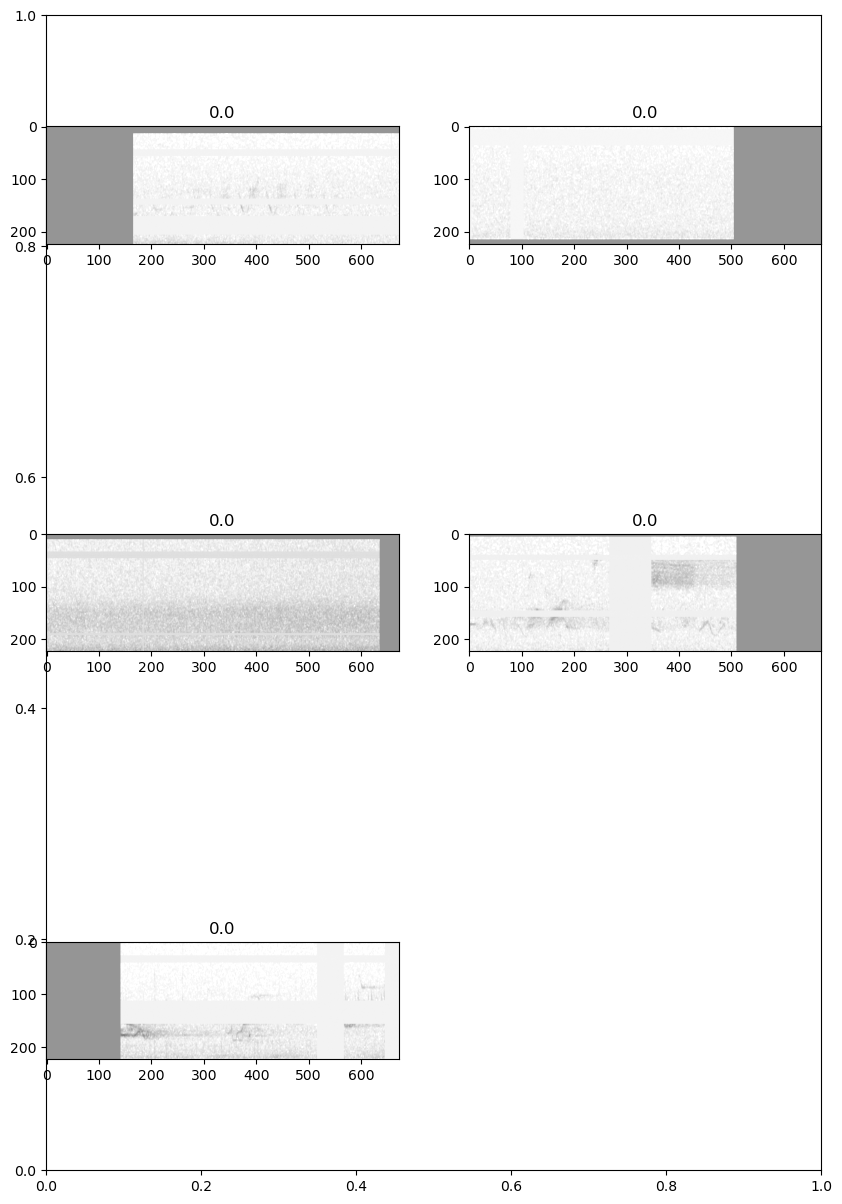

In [4]:
# Turn dataframe into an AudioFileDataset 
train_dataset, valid_dataset = src.data.build.dataset_from_df(df_train_sample, target_species = "OSFL", download_n=0, one_class=False)

## Resample the dataframes in the AudioFileDataset to get fewer no-call samples
Training set is huge, and training is very slow, so downsample the abundant absent class.

In [5]:
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([ 289., 4347.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([  90., 1166.])))

### Downsample the absent class

In [6]:
def downsample_absent_class(ds: opso.AudioFileDataset):
    n_present = int(ds.class_counts()[1][0])
    ds.label_df = opso.data_selection.resample(ds.label_df, n_present)
downsample_absent_class(train_dataset)
downsample_absent_class(valid_dataset)
train_dataset.class_counts(), valid_dataset.class_counts()

((Index(['target_presence', 'target_absence'], dtype='object'),
  array([289., 289.])),
 (Index(['target_presence', 'target_absence'], dtype='object'),
  array([90., 90.])))

# Remove the redundant second label

In [7]:
def drop_absent_class(ds: opso.AudioFileDataset):
    ds.label_df.drop(columns='target_absence', inplace=True)
# drop_absent_class(train_dataset)
# drop_absent_class(valid_dataset)

### Check that the Dataset looks right

In [8]:
train_dataset.label_df.target_presence.value_counts()

target_presence
1.0    289
0.0    289
Name: count, dtype: int64

In [9]:
[train_dataset[i].labels for i in range(25)]

[target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-4605.mp3, 175.5, 178.5), dtype: float64,
 target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-4912.flac, 127.5, 130.5), dtype: float64,
 target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-43757.flac, 3.0, 6.0), dtype: float64,
 target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-43757.flac, 4.5, 7.5), dtype: float64,
 target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-43757.flac, 64.5, 67.5), dtype: float64,
 target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-43757.flac, 148.5, 151.5), dtype: float64,
 target_presence    1.0
 target_absence     0.0
 Name: (../../data/raw/recordings/OSFL/recording-43757.flac, 150.0, 153.0), dtype: float64,
 target_presence    1.0
 target_a

### Can these datasets be interfaced with the fastai dataloaders and training schedules?

In [10]:
from fastai.vision.core import DataLoaders
from fastai.vision.core import DataLoader
# from torch.utils.data._utils.collate import default_collate
# from opensoundscape.ml.utils import collate_audio_samples_to_tensors

In [11]:
from fastai import *
from fastai.vision.all import *

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:121: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  @validator("best_of")
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:140: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  @validator("repetition_penalty")
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-pa

In [12]:
class AudioDatasetWrapper():
    '''
    Alternative behaviour to the __getitem__ method of AudioFileDataset.
    Returns a tuple of the data and the label.
    '''
    def __init__(self, audio_dataset, greyscale_to_rgb=False):
        self.audio_dataset = audio_dataset
        self.greyscale_to_rgb = greyscale_to_rgb

    def __len__(self):
        return len(self.audio_dataset)

    def __getitem__(self, idx):
        # Extract the data tensor
        # Extract the label as an integer in a tensor
        x = self.audio_dataset[idx].data
        y = torch.tensor(int(self.audio_dataset[idx].labels.iloc[0]))

        if self.greyscale_to_rgb:
            x = x.repeat(3, 1, 1)
        
        return (x, y)

def wrap(dataset):
    return AudioDatasetWrapper(dataset)


In [13]:
# wrapped_train_ds = AudioDatasetWrapper(train_dataset, greyscale_to_rgb=True)
# wrapped_valid_ds = AudioDatasetWrapper(valid_dataset, greyscale_to_rgb=True)
# train_dl = DataLoader(wrapped_train_ds, bs=2)
# valid_dl = DataLoader(wrapped_valid_ds, bs=2)

In [14]:
# dls = DataLoaders(train_dl, valid_dl, device="mps")
# len(dls[0])

In [15]:
# learn = Learner(dls, resnet18(), metrics=accuracy, loss_func=nn.CrossEntropyLoss())
# learn.fit_one_cycle(1, 1e-3)

### Training is prohibitively slow using this approach. 

Could be due to :
- Custom AudioDatasetWrapper or other code containing python inefficiencies which should be replaced with tensor operations. 
- OpenSoundScape provides a collate function for getting tuple of tensors from an AudioFileDataset. Tried using this but needs further work. 
- It could be that the process of converting a clip to a spectrogram is just slow, in which case a speedup is possible by precomputing spectrograms. This was tested at the start of the project and it does result in a fast training cycle. 

### Try on a sample of the data just to verify that the training loop does work even if it's slow

In [16]:
# # Make a small sample and check the quantities of each class. 
# small_train_ds = train_dataset.sample(n=100)
# small_valid_ds = valid_dataset.sample(n=20)

# small_train_ds.class_counts(), small_valid_ds.class_counts()

In [17]:
# wrapped_train_ds = AudioDatasetWrapper(small_train_ds, greyscale_to_rgb=True)
# wrapped_valid_ds = AudioDatasetWrapper(small_valid_ds, greyscale_to_rgb=True)
# train_dl = DataLoader(wrapped_train_ds, bs=16)
# valid_dl = DataLoader(wrapped_valid_ds, bs=16)

In [18]:
# dls = DataLoaders(train_dl, valid_dl, device="mps")

In [19]:
# dls.one_batch()[0].shape, dls.num_workers

In [20]:
# learn = Learner(dls, resnet18(), metrics=accuracy, loss_func=nn.CrossEntropyLoss())
# learn.fit_one_cycle(4, 1e-3)

Using a wrapper here is not the way to go - on a subset of 800 spectrograms, the training loop was too slow and isn't showing any convergence. We can see the coarse nature of the data as one sample from the validation set gets classified differently causing a tiny increase in accuracy. 

It takes 4m41s to train 4 epochs

###  Try using the opensoundscape custom collate function

This might be quicker

In [21]:
type(train_dataset[0])

opensoundscape.sample.AudioSample

__collate_audio_samples_to_tensors__ takes a list of AudioSamples and batches them into tensors. This is the behaviour we need.

In [22]:
train_dataset.__getitem__(0)

AudioSample(source=../../data/raw/recordings/OSFL/recording-4605.mp3, start_time=175.5,end_time=178.5, labels=target_presence    1.0
target_absence     0.0
Name: (../../data/raw/recordings/OSFL/recording-4605.mp3, 175.5, 178.5), dtype: float64)

In [23]:
collate_test = opso.ml.utils.collate_audio_samples_to_tensors([train_dataset[i] for i in range(4)])
collate_test[0].shape, collate_test[1].shape, collate_test[0].ndim, collate_test[1].ndim

(torch.Size([4, 1, 224, 672]), torch.Size([4, 2]), 4, 2)

The leading dimension is the batch dimension. The 2 dimensional target highlights that the data is structured with two target classes: 'present' and 'absent'. Since we're currently only using these two classes, the data could be represented with only one of these classes since the presence of one always indicates the absence of the other. 

Different loss fucntins require different shaped targets. For example, nn.CrossEntropyLoss

In [24]:
nn.CrossEntropyLoss

torch.nn.modules.loss.CrossEntropyLoss

In [25]:
train_dataset[0].labels

target_presence    1.0
target_absence     0.0
Name: (../../data/raw/recordings/OSFL/recording-4605.mp3, 175.5, 178.5), dtype: float64

In [26]:
from opensoundscape.preprocess.utils import show_tensor_grid, show_tensor
show_tensor

<function opensoundscape.preprocess.utils.show_tensor(tensor, channel=None, transform_from_zero_centered=True, invert=False)>

In [27]:
train_dataset.class_counts()

(Index(['target_presence', 'target_absence'], dtype='object'),
 array([289., 289.]))

In [ ]:
# def collate_audio_samples_to_float_tensor(batch):
#     tensors = torch.stack([i.data for i in batch])
#     labels = torch.tensor([i.labels.tolist() for i in batch])
#     return tensors, labels


In [28]:
train_dataloader = DataLoader(
    train_dataset,
    bs=64,
    shuffle=True,
    create_batch = opso.ml.utils.collate_audio_samples_to_tensors,
)
valid_dataloader = DataLoader(
    valid_dataset,
    bs=64,
    shuffle=False,
    create_batch = opso.ml.utils.collate_audio_samples_to_tensors,
)


In [29]:
valid_dataloader.one_batch()[1][:5]

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

Passing `create_batch = opso.ml.utils.collate_audio_samples_to_tensors` into `DataLoader` gives the expected behaviour of returning a collated set of tensors containing example spectrograms and their labels.

In [30]:
dls = DataLoaders(train_dataloader,valid_dataloader, device="mps")

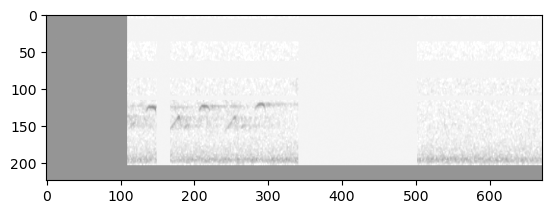

In [31]:
# training set spectrograms have augmentations:
show_tensor(dls.train.one_batch()[0].cpu()[0])

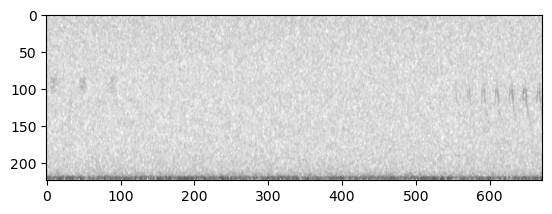

In [32]:
# no augmentations on the validation set:
show_tensor(dls.valid.one_batch()[0].cpu()[0])

### Check shape of input

In [102]:
batch = dls.one_batch()
target = batch[1]
batch

(tensor([[[[ 0.0000,  0.0000,  0.0000,  ..., -0.9768, -1.0429, -1.1713],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.9950, -1.0842, -1.2033],
           [ 0.0000,  0.0000,  0.0000,  ..., -1.1072, -1.1866, -1.3144],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ..., -0.7004, -0.7537, -0.8029],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.9088, -0.9362, -0.9670],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.9433, -0.9682, -1.0027]]],
 
 
         [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ..., -0.7475, -0.7332, -0.7470],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.7575, -0.7497, -0.7358],
           [ 0.0000,  0.0000,  0.0000,  ..., -0.7438, -0.7474, -0.7340]]],
 
 
         [[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
       

In [87]:
type(batch[0])

torch.Tensor

Create a model and a learner

In [100]:
model = timm.create_model('resnet18',pretrained=True, in_chans=1, num_classes=1)
learn = Learner(dls,model,metrics=accuracy,loss_func=CrossEntropyLossFlat())
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: MPS backend out of memory (MPS allocated: 17.39 GB, other allocations: 319.51 MB, max allowed: 18.13 GB). Tried to allocate 588.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [83]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time


ValueError: Expected input batch_size (64) to match target batch_size (128).

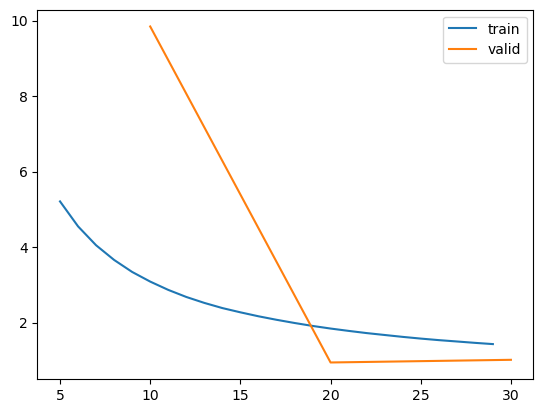

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.predict(train_dataset[0])

AttributeError: 'AudioFileDataset' object has no attribute 'decode_batch'

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape
model(xb).shape, yb.shape

(torch.Size([64, 2]), torch.Size([64, 2]))

In [ ]:
learn.summary()

ResNet (Input shape: 64 x 1 x 224 x 672)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 336 
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 168  
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                          

`PreprocessingError: failed to preprocess sample from path: ../../data/raw/recordings/OSFL/recording-104149.mp3`

try setting out_of_bounds_ok=True in Spectrogram or cleaning out these samples

There doesn't seem to be anything wrong with the recording - it's a 10 minute mp3 file. During preprocessing there's a bandpass operation which seems to fail for this sample. The error can be replecated by setting the upper bandpass frequency too high - higher than any of the frequencies in the spectrogram data. It makes sense that this should throw an error: cutting out frequencies which do not exist is meaningless.

Why is this happening for this sample when it otherwise looks normal?

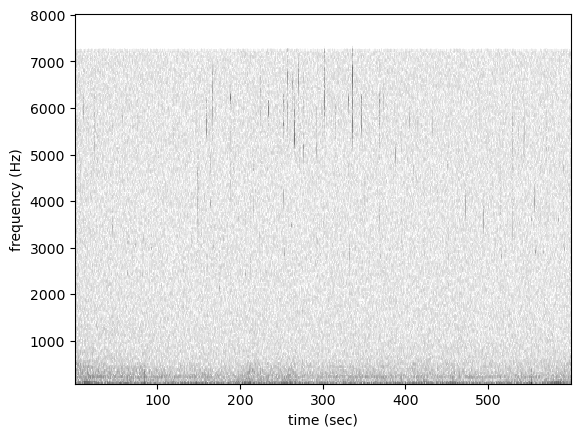

(None,
 array([   0.  ,   31.25,   62.5 ,   93.75,  125.  ,  156.25,  187.5 ,
         218.75,  250.  ,  281.25,  312.5 ,  343.75,  375.  ,  406.25,
         437.5 ,  468.75,  500.  ,  531.25,  562.5 ,  593.75,  625.  ,
         656.25,  687.5 ,  718.75,  750.  ,  781.25,  812.5 ,  843.75,
         875.  ,  906.25,  937.5 ,  968.75, 1000.  , 1031.25, 1062.5 ,
        1093.75, 1125.  , 1156.25, 1187.5 , 1218.75, 1250.  , 1281.25,
        1312.5 , 1343.75, 1375.  , 1406.25, 1437.5 , 1468.75, 1500.  ,
        1531.25, 1562.5 , 1593.75, 1625.  , 1656.25, 1687.5 , 1718.75,
        1750.  , 1781.25, 1812.5 , 1843.75, 1875.  , 1906.25, 1937.5 ,
        1968.75, 2000.  , 2031.25, 2062.5 , 2093.75, 2125.  , 2156.25,
        2187.5 , 2218.75, 2250.  , 2281.25, 2312.5 , 2343.75, 2375.  ,
        2406.25, 2437.5 , 2468.75, 2500.  , 2531.25, 2562.5 , 2593.75,
        2625.  , 2656.25, 2687.5 , 2718.75, 2750.  , 2781.25, 2812.5 ,
        2843.75, 2875.  , 2906.25, 2937.5 , 2968.75, 3000.  , 3031.25,

In [ ]:
error = opso.Audio.from_file('../../data/raw/recordings/OSFL/recording-104149.mp3')
spec = opso.Spectrogram.from_audio(error)
bandpass_spec = spec.bandpass(100, 9000, out_of_bounds_ok=False)
bandpass_spec.plot(), spec.frequencies

In [ ]:
problematic_path = Path("../../data/raw/recordings/OSFL/recording-104149.mp3")


In [ ]:
multi_df = train_dataset.label_df
multi_df.index[0][0], problematic_path

(Path('../../data/raw/recordings/OSFL/recording-4396.mp3'),
 Path('../../data/raw/recordings/OSFL/recording-104149.mp3'))

In [ ]:
multi_df

target_presence  \
file                                                 start_time end_time                    
../../data/raw/recordings/OSFL/recording-4396.mp3    0.0        3.0                   0.0   
                                                     1.5        4.5                   0.0   
                                                     3.0        6.0                   0.0   
                                                     4.5        7.5                   0.0   
                                                     6.0        9.0                   0.0   
...                                                                                   ...   
../../data/raw/recordings/OSFL/recording-813326.flac 127.5      130.5                 0.0   
                                                     129.0      132.0                 0.0   
                                                     130.5      133.5                 0.0   
                                                     132.0      135.0                 0.0   
                                                     135.0      138.0                 1.0   

                                                                          target_absence  
file                                                 start_time end_time                  
../../data/raw/recordings/OSFL/recording-4396.mp3    0.0        3.0                  1.0  
                                                     1.5        4.5                  1.0  
                                                     3.0        6.0                  1.0  
                                                     4.5        7.5                  1.0  
                                                     6.0        9.0                  1.0  
...                                                                                  ...  
../../data/raw/recordings/OSFL/recording-813326.flac 127.5      130.5                1.0  
                                                     129.0      132.0                1.0  
                                                     130.5      133.5                1.0  
                                                     132.0      135.0                1.0  
                                                     135.0      138.0                0.0  

[37511 rows x 2 columns]

In [ ]:

# Create a boolean mask to select rows with the specified path
mask = multi_df.index.get_level_values("file") != (problematic_path)
len(mask)

37511

In [ ]:

# Use the boolean mask to select the rows you want to keep
filtered_df = multi_df.loc[mask]

### Try importing the model from timm
The timm library should handle this channel mismatch by adding the weights from each of the channels into one greyscale channel. Another approach is to duplicate the channels in the greyscale image to create a 3 channel image by using torch.stack or tensor.repeat.

custom model https://forums.fast.ai/t/fastai-v2-pretrained-unet-with-different-number-of-channels/85776

### Check what order the preprocessing happens in opso


In [ ]:
train_dataset.preprocessor.pipeline

load_audio                              Action calling <bound method Audio.from_file of <class 'opensoundscape.audio.Audio'>>
random_trim_audio                                            Augmentation Action calling <function trim_audio at 0x298bb23b0>
trim_audio                                                                Action calling <function trim_audio at 0x298bb23b0>
to_spec              Action calling <bound method Spectrogram.from_audio of <class 'opensoundscape.spectrogram.Spectrogram'>>
bandpass                                                        Action calling <function Spectrogram.bandpass at 0x287124c10>
to_tensor                                                                                                              Action
time_mask                                                     Augmentation Action calling <function time_mask at 0x298bb3490>
frequency_mask                                           Augmentation Action calling <function frequency_mask at 0x298

If we preprocess the spectrograms and save them to disk, we lose the flexibility to easily switch between different spectrogram parameter settings. Mixup would be affected too, since this should be applied at the audio level. The rest of the hyperparameters would be applicable to a preprocessed spectrogram. 


In [ ]:
# osfl_dl = DataLoader(training_dataset, bs=16, before_batch = custom_collate)
# osfl_dl.one_batch()

The \__getitem__ method contained in the AudioDataSet doesn't directly return the tensors. Fastai expects the DataSet to be an iterable of tensors, so we'll make a custom collate function to provide these:

### Problem: the tensors from different recordings were being converted to tensors of different sizes. 

Look into why this is - the spectrograms need to all be the same dimensions. Fixed by setting a spectrogram height and width parameter, but could look further into this and find a better way of enabling same size tensors. 

This is now fixed by forcing resize of the spectrogram during preprocess stage. 